In [6]:
# -------------------------
# Import Libraries
# -------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Geospatial
import folium
from folium.plugins import HeatMap

# -------------------------
# Load Dataset
# -------------------------
file_path = "Vehicles0515.csv"   # Adjust if needed
df = pd.read_csv(file_path, low_memory=False)

# Preview dataset
print("Dataset Shape:", df.shape)
print("\nDataset Columns:\n", df.columns.tolist())
print("\nSample Data:\n", df.head())

# -------------------------
# Data Preprocessing
# -------------------------

# Check datetime column (UK dataset usually has 'Accident_Reference' linked to another table)
# If Date/Time column exists, parse it:
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["DayOfWeek"] = df["Date"].dt.day_name()

if "Time" in df.columns:
    df["Hour"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce").dt.hour

# -------------------------
# Exploratory Data Analysis
# -------------------------

# 1. Accidents by Year
if "Year" in df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x="Year", palette="viridis")
    plt.title("Accidents by Year")
    plt.xticks(rotation=45)
    plt.show()

# 2. Accidents by Hour of Day
if "Hour" in df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x="Hour", palette="coolwarm")
    plt.title("Accidents by Hour of Day")
    plt.show()

# 3. Accidents by Day of Week
if "DayOfWeek" in df.columns:
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x="DayOfWeek",
                  order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
                  palette="magma")
    plt.title("Accidents by Day of Week")
    plt.show()

# 4. Accidents by Weather (if available)
weather_cols = [c for c in df.columns if "Weather" in c]
if weather_cols:
    col = weather_cols[0]
    plt.figure(figsize=(12,6))
    df[col].value_counts().head(10).plot(kind="bar", color="darkgreen")
    plt.title(f"Top 10 Weather Conditions in Accidents ({col})")
    plt.xlabel("Weather Condition")
    plt.ylabel("Number of Accidents")
    plt.show()

# 5. Accident Severity Distribution
severity_cols = [c for c in df.columns if "Severity" in c or "Casualty" in c]
if severity_cols:
    col = severity_cols[0]
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, palette="Set2")
    plt.title("Accident Severity Distribution")
    plt.show()

# -------------------------
# Hotspot Visualization (Heatmap)
# -------------------------
# UK dataset usually has Latitude/Longitude columns
lat_col = [c for c in df.columns if "Lat" in c or "Latitude" in c]
lng_col = [c for c in df.columns if "Lng" in c or "Longitude" in c]

if lat_col and lng_col:
    sample_df = df.dropna(subset=[lat_col[0], lng_col[0]]).sample(3000, random_state=42)

    m = folium.Map(location=[sample_df[lat_col[0]].mean(), sample_df[lng_col[0]].mean()], zoom_start=6)
    heat_data = list(zip(sample_df[lat_col[0]], sample_df[lng_col[0]]))
    HeatMap(heat_data, radius=7).add_to(m)

    m.save("accident_hotspots.html")
    print("✅ Accident hotspot map saved as accident_hotspots.html (open in browser)")

# -------------------------
# Insights
# -------------------------
print("\n--- Quick Insights ---")
if "Year" in df.columns:
    print("Most accidents recorded in year:", df["Year"].value_counts().idxmax())

if "Hour" in df.columns:
    print("Peak accident hour:", df["Hour"].value_counts().idxmax())

if weather_cols:
    print("Most common weather condition during accidents:", df[weather_cols[0]].value_counts().idxmax())

if severity_cols:
    print("Most frequent severity level:", df[severity_cols[0]].value_counts().idxmax())


Dataset Shape: (115548, 22)

Dataset Columns:
 ['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Vehicle_Location-Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?', 'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver', 'Age_Band_of_Driver', 'Engine_Capacity_(CC)', 'Propulsion_Code', 'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type']

Sample Data:
   Accident_Index  Vehicle_Reference  Vehicle_Type  Towing_and_Articulation  \
0  200501BS00001                  1           9.0                      0.0   
1  200501BS00002                  1          11.0                      0.0   
2  200501BS00003                  1          11.0                      0.0   
3  200501BS00003                  2           9.0                      0.0   
4  200501BS00004      

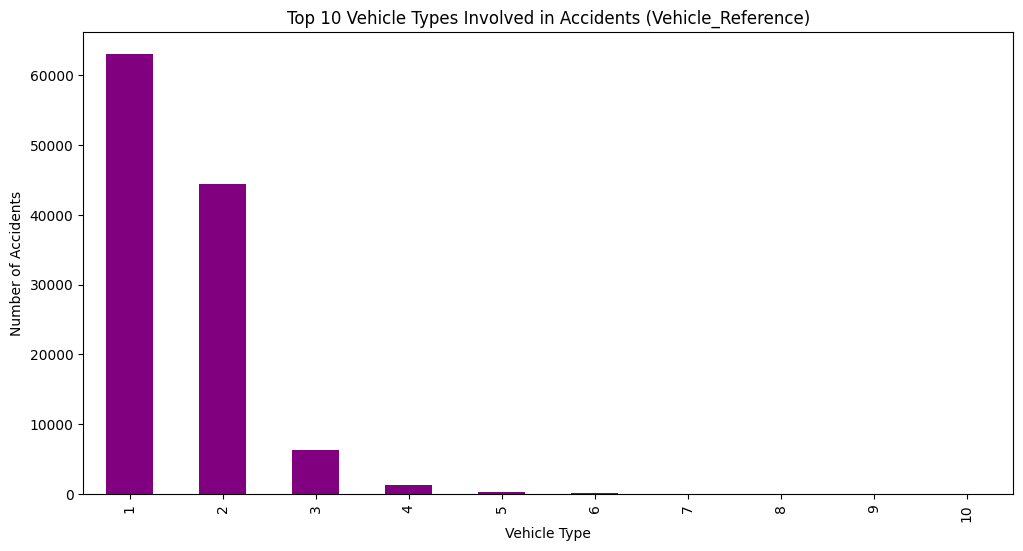

In [7]:
# -------------------------
# Extra Visualizations
# -------------------------

# 6. Accidents Trend Over Time (Monthly)
if "Year" in df.columns and "Month" in df.columns:
    monthly_trend = df.groupby(["Year","Month"]).size().reset_index(name="Accidents")
    monthly_trend["Date"] = pd.to_datetime(monthly_trend["Year"].astype(str) + "-" + monthly_trend["Month"].astype(str) + "-01")

    plt.figure(figsize=(14,6))
    plt.plot(monthly_trend["Date"], monthly_trend["Accidents"], marker="o", color="blue")
    plt.title("Monthly Accident Trends Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Accidents")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# 7. Heatmap of Accidents by Day and Hour
if "DayOfWeek" in df.columns and "Hour" in df.columns:
    pivot_table = pd.crosstab(df["DayOfWeek"], df["Hour"])
    # Ensure days are in correct order
    pivot_table = pivot_table.reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

    plt.figure(figsize=(12,6))
    sns.heatmap(pivot_table, cmap="YlOrRd")
    plt.title("Accidents Heatmap (Day of Week vs Hour of Day)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()

# 8. Top Vehicle Types Involved in Accidents (if available)
vehicle_cols = [c for c in df.columns if "Vehicle" in c or "Car" in c]
if vehicle_cols:
    col = vehicle_cols[0]
    plt.figure(figsize=(12,6))
    df[col].value_counts().head(10).plot(kind="bar", color="purple")
    plt.title(f"Top 10 Vehicle Types Involved in Accidents ({col})")
    plt.xlabel("Vehicle Type")
    plt.ylabel("Number of Accidents")
    plt.show()

# 9. Severity vs Hour of Day
if "Hour" in df.columns and severity_cols:
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x="Hour", hue=severity_cols[0], palette="Set1")
    plt.title("Accident Severity Distribution by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Number of Accidents")
    plt.legend(title="Severity")
    plt.show()

# 10. Severity vs Weather Condition
if weather_cols and severity_cols:
    plt.figure(figsize=(14,6))
    sns.countplot(data=df, x=weather_cols[0], hue=severity_cols[0], palette="viridis",
                  order=df[weather_cols[0]].value_counts().head(8).index)
    plt.title("Accident Severity by Weather Condition")
    plt.xticks(rotation=45)
    plt.xlabel("Weather Condition")
    plt.ylabel("Number of Accidents")
    plt.legend(title="Severity")
    plt.show()
